In [1]:
import random
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from instancePDSVRP import instancePDSVRP
import copy
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import seaborn as sns
import heuristic as h
import utilities as u

In [2]:
# Parameter ranges
param_ranges = {
    'num_customers': (10, 100),
    'grid_size': (20, 40),
    'num_drones': (1, 20),
    'battery_endurance': (0.25, 1.0),  # in hours
    'cost_ratio': (10.0, 50.0)
}

# Constants
constants = {
    'truck_speed': 30.0,
    'drone_speed': 40.0,
    'truck_capacity': 1300.0,
    'drone_capacity': 2.27,
    'drone_unit_cost': 0.03,
    'work_time_limit': 8.0
}

num_instances = 300

In [3]:
def generate_instance(num_custumers, grid_size, num_drones, battery_endurance, cost_ratio):
    custumers = []
    
    depot = [{
        'x': random.uniform(0, grid_size),
        'y': random.uniform(0, grid_size),
        'demand': 0.00
    }]
    
    custumers = [
            {
                'x': random.uniform(0, grid_size),
                'y': random.uniform(0, grid_size),
                'demand': random.uniform(0, 2.27) if np.random.rand() < 0.86 else random.uniform(2.27, 68) 
            }
            for _ in range(num_custumers)
        ]
    
    all_entities  = depot + custumers
    
    header = (
        f"NUM DRONES,{num_drones}\n"
        f"NUM TRUCKS,{10}\n"
        f"TRUCK CAP,{constants['truck_capacity']}\n"
        f"DRONE CAP,{constants['drone_capacity']}\n"
        f"TRUCK SPEED,{constants['truck_speed']}\n"
        f"DRONE SPEED,{constants['drone_speed']}\n"
        f"DRONE ENDURANCE,{battery_endurance:.2f}\n"
        f"DRONE TIME LIMIT,{constants['work_time_limit']}\n"
        f"TRUCK TIME LIMIT,{constants['work_time_limit']}\n"
        f"TRUCK UNIT COST,{cost_ratio * constants['drone_unit_cost']:.2f}\n"
        f"DRONE UNIT COST,{constants['drone_unit_cost']}\n"
    )
    customer_lines = "\n".join(
        f"{i}\t{customer['x']:.2f}\t{customer['y']:.2f}\t{customer['demand']:.2f}"
        for i, customer in enumerate(all_entities)
    )
    return header + customer_lines

In [4]:
instances = []
params = []

for _ in range(num_instances):
    int_params = {
        'num_custumers': random.randint(*param_ranges['num_customers']),
        'grid_size': random.randint(*param_ranges['grid_size']),
        'num_drones': random.randint(*param_ranges['num_drones']),
        'battery_endurance': random.uniform(*param_ranges['battery_endurance']),
        'cost_ratio': random.uniform(*param_ranges['cost_ratio']),
    }
    params.append(int_params)
    instances.append(generate_instance(int_params['num_custumers'], int_params['grid_size'], int_params['num_drones'], int_params['battery_endurance'], int_params['cost_ratio']))

df = pd.DataFrame(params)

In [6]:
for index, instance in enumerate(instances):
    with open('./instances/generated_instances/'+ str(index) + '-r-r' '.txt', 'w') as file:
        file.write(str(instance))

In [7]:
def compute_cost_saving(instance, sigma, c_average_removed, L_max, w1, w2, w3, w4, w5, gamma, n_nearest, delta, epsilon, iter_imp, iter_max, p_min, p_max, max_unfeasible_swaps_perturb):    
    instance_no_drones = copy.deepcopy(instance)
    instance_no_drones.D = 0
        
    sol_drones = h.SISSRs(instance, sigma, c_average_removed, L_max, w1, w2, w3, w4, w5, gamma, n_nearest, delta, epsilon, iter_imp, iter_max, p_min, p_max, max_unfeasible_swaps_perturb)
    sol_no_drones = h.SISSRs(instance_no_drones, sigma, c_average_removed, L_max, w1, w2, w3, w4, w5, gamma, n_nearest, delta, epsilon, iter_imp, iter_max, p_min, p_max, max_unfeasible_swaps_perturb)
    
    cost_with_drones = u.cost(instance, sol_drones)
    cost_without_drones = u.cost(instance_no_drones, sol_no_drones)
    
    cost_saving = 100 * (cost_without_drones - cost_with_drones) / cost_without_drones
    return cost_saving

In [ ]:
# Apply the function to each instance
cost_savings = []

instances_name_files = []
for index in range(num_instances):
    instances_name_files.append(str(index) + "-r-r.txt")
            
for name_file_instance in instances_name_files:
    instance = instancePDSVRP("instances/generated_instances/" + name_file_instance)
    print("instance: ", name_file_instance)
    p_min = (int)(min(3, instance.N * 0.1))
    p_max = (int)(instance.N * 0.1)
    cost_savings.append(compute_cost_saving(instance, 0.3, instance.N * 0.15, instance.N * 0.15, 5,1,1,2,2, 0.1, 20, 0.1, 0.999975, 30, 300, p_min, p_max, 9))
    
df['cost_savings'] = cost_savings

In [ ]:
df.to_csv("results/sensitivity_analysis_results.csv")
df

In [15]:
#df = pd.read_csv("results/sensitivity_analysis_results2.csv")

In [19]:
# Features
X = df[['num_custumers', 'grid_size', 'num_drones', 'battery_endurance', 'cost_ratio']]

# Target
y = df['cost_savings']

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
regressor = DecisionTreeRegressor(max_depth=4, min_samples_leaf=9, random_state=42)

regressor.fit(X, y)
'''
y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
'''

'\ny_pred = regressor.predict(X_test)\nmse = mean_squared_error(y_test, y_pred)\nprint(f"Mean Squared Error: {mse}")\n'

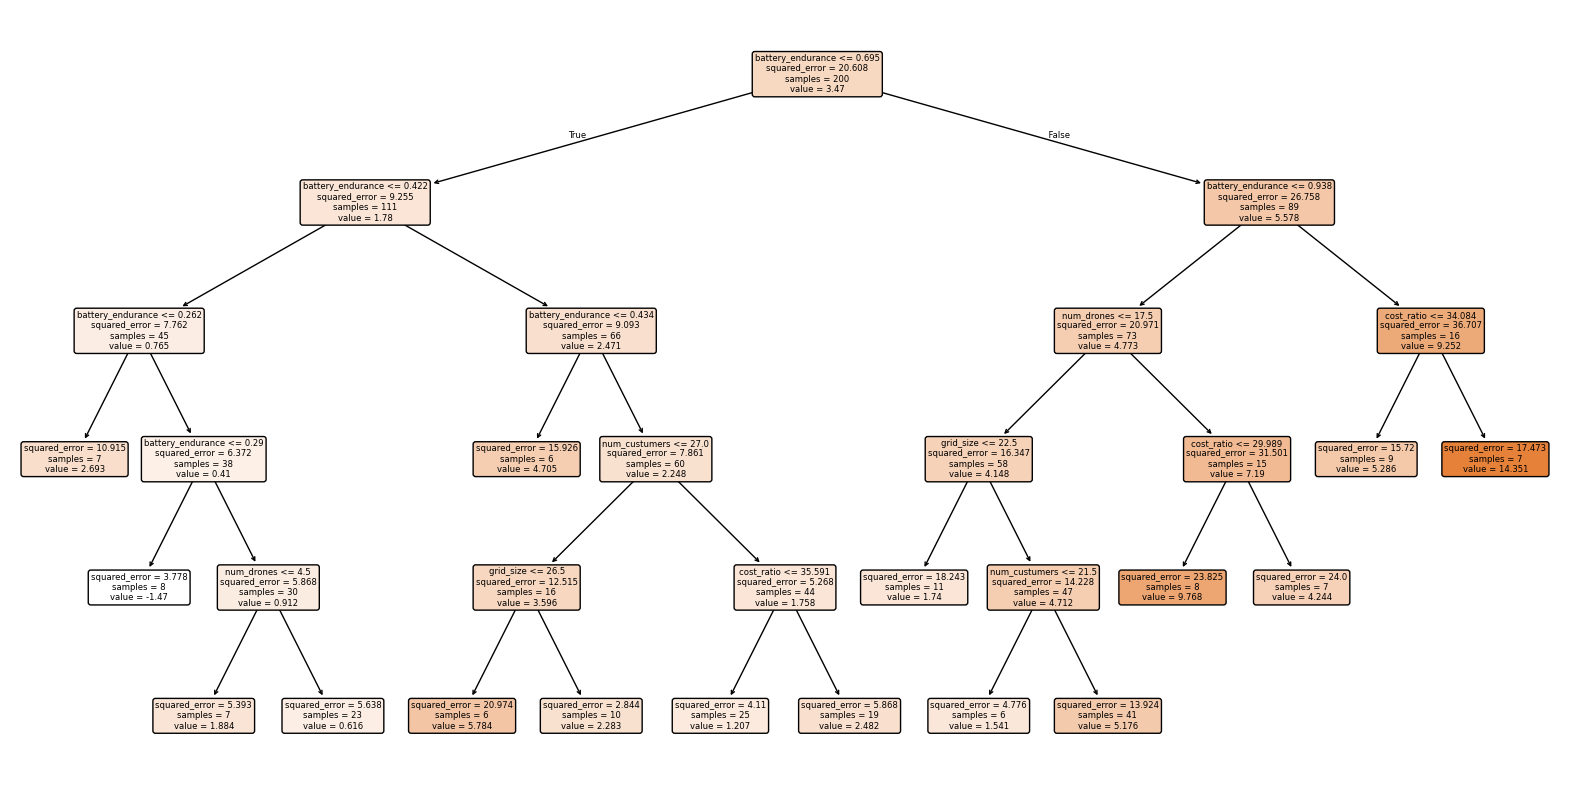

In [17]:
plt.figure(figsize=(20,10))
plot_tree(regressor, feature_names=X.columns, filled=True, rounded=True)
plt.show()

[0.05548514 0.06360146 0.06062687 0.58825037 0.23203616]
       num_custumers   grid_size  num_drones  battery_endurance  cost_ratio
count      200.00000  200.000000  200.000000         200.000000  200.000000
mean        56.21500   29.500000   10.835000           0.625537   31.534695
std         27.10187    6.211515    5.939204           0.220584   11.064402
min         10.00000   20.000000    1.000000           0.252285   10.083603
25%         29.00000   24.000000    6.000000           0.433460   23.239477
50%         58.50000   29.000000   11.000000           0.635766   31.441433
75%         80.00000   35.000000   16.000000           0.794865   40.510981
max        100.00000   40.000000   20.000000           0.998920   49.966338
count    200.000000
mean       3.470114
std        4.550984
min       -7.163896
25%        0.376532
50%        2.675139
75%        5.362026
max       21.251539
Name: cost_savings, dtype: float64
{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 5,

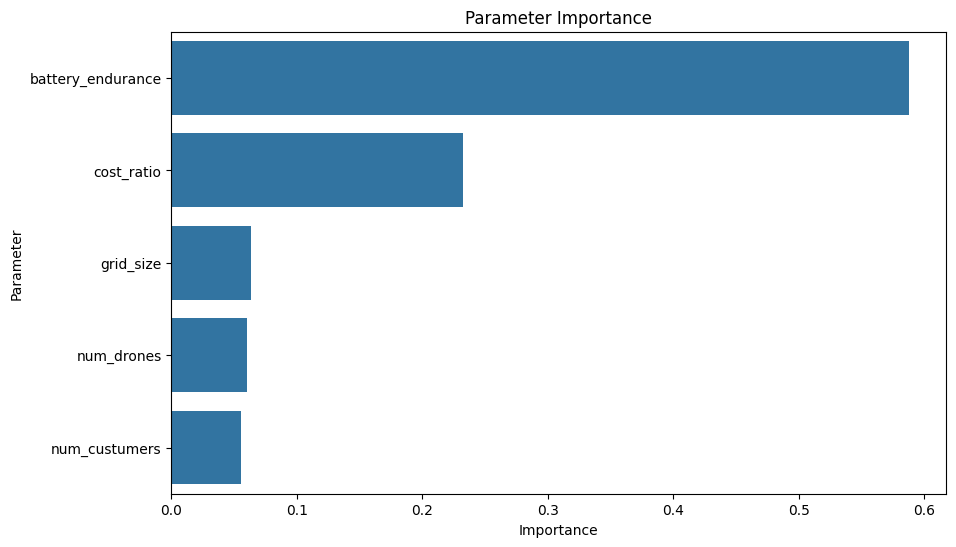

In [18]:
# Retrieve the feature importances
feature_importances = regressor.feature_importances_
print(feature_importances)

print(X.describe())
print(y.describe())
print(regressor.get_params())


# Create a dataframe for better visualization
importance_df = pd.DataFrame({
    'Parameter': X.columns,
    'Importance': feature_importances
})

# Normalize the importance values
importance_df['Importance'] = importance_df['Importance'] / importance_df['Importance'].sum()

# Sort the dataframe by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the dataframe
print(importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Parameter')
plt.title('Parameter Importance')
plt.show()